In [ ]:
# imports
from transformers import AutoTokenizer, AutoModelForMaskedLM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
import pickle
from datasets import Dataset
import seaborn as sns
from metrics import contextual_precision, contextual_recall, contextual_relevancy

In [2]:
# !pip install faiss-cpu
# !pip uninstall faiss-cpu
# !pip install langchain_community
# !pip install sentence_transformers
# !pip install pyarrow
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from sentence_transformers import SentenceTransformer, losses, InputExample
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device

device(type='cuda')

In [4]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3070 Laptop GPU'

## Torch fine-tuning

In [ ]:
file_path = 'train-00000-of-00007.parquet'  # Adjust the file path as necessary
train_df = pd.read_parquet(file_path)

In [ ]:
train_examples = []

# # Prepare InputExamples
queries = train_df['query'].to_list()
passages = train_df['passages'].to_list()

for index, query in enumerate(queries):
  
    # Append passages as positive examples with the same label
    for passage in passages[index]['passage_text']:
      
      rint_one  = np.random.randint(0, len(passages))
      
      while rint_one == index:
        rint_one  = np.random.randint(0, len(passages))
        
      rint_two  = np.random.randint(0, len(passages[rint_one]['passage_text']))
      
      train_examples.append((query, passage, passages[rint_one]['passage_text'][rint_two]))

In [ ]:
# Setting up the dataloader
class TripletDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]
        return anchor, positive, negative
    
triplet_dataset = TripletDataset(train_examples)
triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
tokenizer = model.tokenizer

In [ ]:
criterion = torch.nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - torch.nn.functional.cosine_similarity(x, y))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def embed(text):
    encoded_inputs = model.tokenize(text)
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    embeddings = model({'input_ids': input_ids, 'attention_mask': attention_mask})
    return embeddings['sentence_embedding']

loss_per_batch = []

model.train()
for i, batch in enumerate(tqdm(triplet_loader)):
    
    query = embed(batch[0])
    positive = embed(batch[1])
    negative = embed(batch[2])
    
    optimizer.zero_grad()
    loss = criterion(query, positive, negative)
    loss.backward()
    optimizer.step()

    loss_per_batch.append(loss.item())
    if i % 2000 == 0:
        model.save(f'chks/all-MiniLM-L6-v2-train-0000/batch_{i:06d}')

In [80]:
file_path = 'test-00000-of-00001.parquet'  # Adjust the file path as necessary
df = pd.read_parquet(file_path)

In [99]:
model= SentenceTransformer('chks/all-MiniLM-L6-v2-train-0000/batch_004000', device=device)
# out = model_cpu(model_cpu.tokenize(batch[1]))

In [82]:
index = faiss.IndexFlatIP(384)
# index_gpu = faiss.index_cpu_to_all_gpus(index)

def embedding_function(text):
    # inputs = tokenizer(text, return_tensors="pt")
    # outputs = model(**inputs)
    # return outputs.last_hidden_state.detach().numpy()[0, 0]
    embeddings = model.encode(text)
    return embeddings / np.linalg.norm(embeddings)


vector_store = FAISS(
    embedding_function=embedding_function,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)


`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [83]:
unique_passages = set()
index_to_docstore_id = {}
document_counter = 0
batch_documents = []

# Loop over passages using tqdm for progress tracking
for passages in tqdm(df['passages']):
  for passage in passages['passage_text']:

    passage_text = passage# Assuming the structure of the dict is correct
    tokens = len(model.tokenizer(passage)['input_ids'])

    if tokens <= 256 and passage_text not in unique_passages:
      unique_passages.add(passage_text)  # Add to set
      document = Document(page_content=passage_text)
      batch_documents.append(document)

      index_to_docstore_id[document_counter] = passage_text  # Store mapping
      document_counter += 1

      # Process and add documents in batches
      if len(batch_documents) >= 10000:  # Adjust batch size as necessary
        vector_store.add_documents(documents=batch_documents)
        batch_documents = []  # Clear the batch after adding
          # print('----')

# Add any remaining documents
if batch_documents:
    vector_store.add_documents(documents=batch_documents)


  0%|          | 0/101092 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (259 > 256). Running this sequence through the model will result in indexing errors


In [84]:
import pickle

faiss.write_index(index, "finetune_test_faiss_index.bin")
with open("finetune_test_docstore_metadata.pkl", "wb") as f:
    pickle.dump(index_to_docstore_id, f)

In [ ]:
test_df = pd.read_parquet('test-00000-of-00001.parquet')

In [100]:
loaded_index = faiss.read_index("finetune_test_faiss_index.bin")

with open("finetune_test_docstore_metadata.pkl", "rb") as f:
    loaded_metadata = pickle.load(f)

In [ ]:
def embedding_function(text):
    embeddings = model.encode(text)
    return embeddings / np.linalg.norm(embeddings)



In [ ]:
from sentence_transformers import CrossEncoder
model= SentenceTransformer('chks/all-MiniLM-L6-v2-train-0000/batch_004000', device=device)
reranker_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", default_activation_function=torch.nn.Sigmoid(), device=device)

def rerank(query_text, retrieved_documents):

    query_answer_pairs = [(query_text, passage) for passage in retrieved_documents]
    scores = reranker_model.predict(query_answer_pairs)
    sorted_passages = [p for p, s in sorted(zip(retrieved_documents, scores), key=lambda x: x[1], reverse=True)]

    return sorted_passages

In [112]:
metrics = {}
metrics['precision'] = {}
metrics['recall'] = {}
metrics['relevancy'] = {}

N = 5000
K_list = [3, 5, 10, 100]
for K in K_list:
    metrics['precision'][K] = []
    metrics['recall'][K] = []
    metrics['relevancy'][K] = []

np.random.seed(0)
indices = np.random.choice(len(test_df), N)
for i in tqdm(indices):

    query_text = test_df['query'][i]
    query_embedding = embedding_function(query_text).astype('float32').reshape(1, -1)
    distances, indices = loaded_index.search(query_embedding, K_list[-1])
    retrieved_passages = [loaded_metadata[j] for j in indices[0]]
    reranked_passages = rerank(query_text, retrieved_passages)

    for K in K_list:
        metrics['precision'][K].append(contextual_precision(reranked_passages[:K], test_df['passages'][i]['passage_text']))
        metrics['recall'][K].append(contextual_recall(reranked_passages[:K], test_df['passages'][i]['passage_text']))
        metrics['relevancy'][K].append(contextual_relevancy(reranked_passages[:K], test_df['passages'][i]['passage_text']))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [115]:
with open(f'metrics_{N}_reranked_finetuned.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [ ]:
with open('metrics_5000_reranked_finetuned.pkl', 'rb') as f:
    
    results = pickle.load(f)

fin_results = {}

for key in results.keys():
    
    fin_results[key] = {}
    
    for k in results[key].keys():
        
        fin_results[key][k] = sum(results[key][k])/len(results[key][k])

fin_results3 = pd.DataFrame(fin_results)
fin_results3

,precision,recall,relevancy
3,0.000600,0.00006,0.000200
5,0.000600,0.00006,0.000120
10,0.000600,0.00006,0.000060
100,0.000604,0.00008,0.000008


In [7]:
model = SentenceTransformer('all-MiniLM-L6-v2', device = device)

In [8]:
def embed(text):
    encoded_inputs = model.tokenize(text)
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    embeddings = model({'input_ids': input_ids, 'attention_mask': attention_mask})
    return embeddings['sentence_embedding']

In [9]:
class NN(torch.nn.Module):
    
    def __init__(self) -> None:
        super(NN, self).__init__()
        
        # Define the layers
        self.L1 = torch.nn.Linear(384, 768)  # First linear layer
        self.nL1 = torch.nn.ReLU()           # ReLU activation function
        self.L2 = torch.nn.Linear(768, 384)

    def forward(self, x):
        # Forward pass: Apply L1 -> ReLU -> L2
        x = self.L1(x)      # First linear layer
        x = self.nL1(x)     # Apply ReLU activation
        x = self.L2(x)
        return x

In [10]:
linear_model = NN().to(device)

file_path = 'train-00000-of-00007.parquet'  # Adjust the file path as necessary
df = pd.read_parquet(file_path)
train_examples = []

# # Prepare InputExamples
queries = df['query'].to_list()
passages = df['passages'].to_list()

for index, query in enumerate(queries):
  
    # Append passages as positive examples with the same label
    # for passage in passages[index]['passage_text']:
    passage = np.random.choice(passages[index]['passage_text'])
    train_examples.append((query, passage))

In [20]:
class TripletDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor, positive = self.triplets[idx]
        return anchor, positive
    
triplet_dataset = TripletDataset(train_examples)
np.random.seed(0)
sample_indices = np.random.choice(range(len(triplet_dataset)), len(triplet_dataset)//10, replace=False)
triplet_dataset_sampled = Subset(triplet_dataset, sample_indices)
triplet_loader = DataLoader(triplet_dataset_sampled, batch_size=64, shuffle=True)

In [19]:
linear_model = NN().to(device)

file_path = 'train-00000-of-00007.parquet'  # Adjust the file path as necessary
df = pd.read_parquet(file_path)
train_examples = []

queries = df['query'].to_list()
passages = df['passages'].to_list()

for index, query in enumerate(queries):
  
    passage = np.random.choice(passages[index]['passage_text'])
    # train_examples.append(InputExample(texts=[query, passage]))
    train_examples.append((query, passage))

In [ ]:
# criterion = torch.nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - torch.nn.functional.cosine_similarity(x, y))
# criterion = torch.nn.CosineEmbeddingLoss()
criterion = losses.MultipleNegativesRankingLoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr=1e-5)

loss_per_batch = []
max_epochs = 1
cnt = 0
epoch_losses = []

model.train()
for epoch in range(max_epochs):
    
    epoch_loss = 0
    
    for i, batch in enumerate(tqdm(triplet_loader)):
        
        optimizer.zero_grad()
        query = embed(batch[0]).detach()
        positive = embed(batch[1]).detach()
        
        query = linear_model.forward(query)
        positive = linear_model.forward(positive)
        
        target = torch.ones(query.size(0)).to(device)
        
        loss = criterion(query, positive, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # loss_per_batch.append(loss.item())
        
        # if cnt %10 == 0:
            
        #     print(loss)
        # cnt +=1
    print(epoch_loss)
    epoch_losses.append(epoch_loss)    

In [ ]:
criterion = losses.MultipleNegativesRankingLoss(model=model)
optimizer = torch.optim.Adam(linear_model.parameters(), lr=1e-5)

loss_per_batch = []
max_epochs = 1
cnt = 0
epoch_losses = []

model.train()
for epoch in range(max_epochs):
    
    epoch_loss = 0
    
    for anchor, positive in tqdm(triplet_loader):
        
        # with torch.no_grad():
        # sentence_embeddings = model.encode(batch.texts)
        # linear_embeddings = linear_model(torch.tensor(sentence_embeddings))
        
        anchor_embeddings = model.encode(anchor, convert_to_tensor=True)
        positive_embeddings = model.encode(positive, convert_to_tensor=True)
        print(anchor_embeddings.shape, positive_embeddings.shape)
        
        optimizer.zero_grad()  
        loss = criterion(anchor_embeddings, positive_embeddings)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # loss_per_batch.append(loss.item())
        
        # if cnt %10 == 0:
            
        #     print(loss)
        # cnt +=1
    print(epoch_loss)
    epoch_losses.append(epoch_loss)

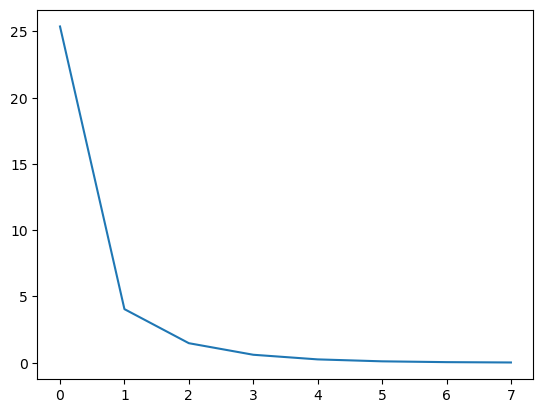

In [106]:
plt.plot(epoch_losses)

In [107]:
torch.save(linear_model.state_dict(), "chks/linear_model.pth")

In [136]:
index = faiss.IndexFlatIP(384)
# index_gpu = faiss.index_cpu_to_all_gpus(index)

def embedding_function(text):
    # inputs = tokenizer(text, return_tensors="pt")
    # outputs = model(**inputs)
    # return outputs.last_hidden_state.detach().numpy()[0, 0]
    embeddings = model.encode(text)
    embeddings = linear_model.forward(torch.tensor(embeddings, dtype = torch.float32).to(device)).detach().to('cpu').numpy()
    return embeddings / np.linalg.norm(embeddings)


vector_store = FAISS(
    embedding_function=embedding_function,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)


`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [ ]:
test_df = pd.read_parquet('test-00000-of-00001.parquet')

In [ ]:
unique_passages = set()
index_to_docstore_id = {}
document_counter = 0
batch_documents = []

# Loop over passages using tqdm for progress tracking
for passages in tqdm(df['passages']):
  for passage in passages['passage_text']:

    passage_text = passage# Assuming the structure of the dict is correct
    tokens = len(model.tokenizer(passage)['input_ids'])

    if tokens <= 256 and passage_text not in unique_passages:
      unique_passages.add(passage_text)  # Add to set
      document = Document(page_content=passage_text)
      batch_documents.append(document)

      index_to_docstore_id[document_counter] = passage_text  # Store mapping
      document_counter += 1

      # Process and add documents in batches
      if len(batch_documents) >= 10000:  # Adjust batch size as necessary
        vector_store.add_documents(documents=batch_documents)
        batch_documents = []  # Clear the batch after adding
          # print('----')

# Add any remaining documents
if batch_documents:
    vector_store.add_documents(documents=batch_documents)

In [ ]:
vector_store.index.ntotal

In [140]:
faiss.write_index(index, "finetune_nn_test_faiss_index.bin")
with open("finetune_nn_test_docstore_metadata.pkl", "wb") as f:
    pickle.dump(index_to_docstore_id, f)

In [141]:
loaded_index = faiss.read_index("finetune_nn_test_faiss_index.bin")

with open("finetune_nn_test_docstore_metadata.pkl", "rb") as f:
    loaded_metadata = pickle.load(f)

In [142]:
metrics = {}
metrics['precision'] = {}
metrics['recall'] = {}
metrics['relevancy'] = {}

N = 5000
K_list = [3, 5, 10, 100]
for K in K_list:
    metrics['precision'][K] = []
    metrics['recall'][K] = []
    metrics['relevancy'][K] = []

np.random.seed(0)
indices = np.random.choice(len(test_df), N)
for i in tqdm(indices):

    query_text = test_df['query'][i]
    query_embedding = embedding_function(query_text).astype('float32').reshape(1, -1)
    distances, indices = loaded_index.search(query_embedding, K_list[-1])
    retrieved_passages = [loaded_metadata[j] for j in indices[0]]

    for K in K_list:
        metrics['precision'][K].append(contextual_precision(retrieved_passages[:K], test_df['passages'][i]['passage_text']))
        metrics['recall'][K].append(contextual_recall(retrieved_passages[:K], test_df['passages'][i]['passage_text']))
        metrics['relevancy'][K].append(contextual_relevancy(retrieved_passages[:K], test_df['passages'][i]['passage_text']))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [143]:
with open(f'metrics_{N}_reranked_finetuned_nn.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [ ]:

with open('metrics_5000_reranked_finetuned_nn.pkl', 'rb') as f:
    
    results = pickle.load(f)

results.keys(), results['precision'].keys()
fin_results = {}

for key in results.keys():
    
    fin_results[key] = {}
    
    for k in results[key].keys():
        
        fin_results[key][k] = sum(results[key][k])/len(results[key][k])

fin_results4 = pd.DataFrame(fin_results)
fin_results4

,precision,recall,relevancy
3,0.578400,0.128887,0.427467
5,0.573965,0.180939,0.360200
10,0.548267,0.249897,0.248940
100,0.441999,0.415558,0.041428


<h1> Finetune Adaptor llama index </h1>

In [ ]:
!pip install llama-index
!pip install llama-index-embeddings-adapter
!pip install llama-index-finetuning

In [6]:
import torch
from typing import Any, List, Optional, Tuple#, Union
# from llama_index.core import SimpleDirectoryReader
# from llama_index.core.base.embeddings.base import BaseEmbedding
# from llama_index.core.node_parser import SentenceSplitter
from llama_index.finetuning import EmbeddingAdapterFinetuneEngine
# from llama_index.finetuning.embeddings.adapter_utils import BaseAdapter
# from llama_index.embeddings.huggingface.base import HuggingFaceEmbedding
# from llama_index.embeddings.huggingface.pooling import Pooling
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset
import pandas as pd
import numpy as np
from llama_index.embeddings.adapter.utils import TwoLayerNN
from llama_index.core.embeddings import resolve_embed_model
from tqdm import tqdm
# from llama_index.embeddings.adapter import AdapterEmbeddingModel

In [12]:
torch.cuda.is_available()

True

In [3]:
train_df = pd.read_parquet('train-00000-of-00007.parquet')

In [4]:
train_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,[The immediate impact of the success of the ma...,"{'is_selected': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",)what was the immediate impact of the success ...,1185869,DESCRIPTION,[]
1,[Restorative justice that fosters dialogue bet...,"{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]...",_________ justice is designed to repair the ha...,1185868,DESCRIPTION,[]
2,[The reasons why Stalin wanted to control East...,"{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]...",why did stalin want control of eastern europe,1185854,DESCRIPTION,[]
3,[Nails rust in water because water allows the ...,"{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]...",why do nails get rusty,1185755,DESCRIPTION,[]
4,"[Depona Ab is a library in Vilhelmina, Sweden.]","{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]...",depona ab,1184773,DESCRIPTION,[]


In [5]:
train_queries = dict()
corpus = dict()
train_relevant_docs = dict()

count = 0

for index, row in train_df.iterrows():
    
    train_queries[f'{index}'] = row['query']
    
    # if len(row['passages']['passage_text']) != 10:
    #     print(index, len(row['passages']['passage_text']))
        
    for corpus_index, passage in enumerate(row['passages']['passage_text']):

        corpus[f'{index}.{corpus_index}'] = passage
    
    train_relevant_docs[f'{index}'] = [f'{index}.{i}' for i in range(len(row['passages']['passage_text']))] 

In [6]:
train_dataset = EmbeddingQAFinetuneDataset(
    queries = train_queries, corpus = corpus, relevant_docs = train_relevant_docs
)

In [7]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
base_embed_model = resolve_embed_model(f"local:{model_name}")

c:\Users\prana\OneDrive\Desktop\IITHyderabad\TNLP\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:2 prompts are loaded, with the keys: ['query', 'text']
2 prompts are loaded, with the keys: ['query', 'text']


In [8]:
adapter_model = TwoLayerNN(
    in_features=384,
    hidden_features=512,
    out_features=384,
    bias=True,
    add_residual=True
)

In [ ]:
finetune_engine = EmbeddingAdapterFinetuneEngine(
    train_dataset,
    base_embed_model,
    model_output_path="chks/llama_index/all-MiniLM-L6-v2-finetuned-TwoLayerNN",
    adapter_model=adapter_model,
    epochs=5,
    verbose=False,
    device="cuda",
    batch_size = 64
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


In [ ]:
finetune_engine.finetune()

In [15]:
import json
# Paths to the saved files
model_path = "chks/llama_index/all-MiniLM-L6-v2-finetuned-TwoLayerNN-v2"
config_path = f"{model_path}/config.json"
model_weights_path = f"{model_path}/pytorch_model.bin"

# Load the config
with open(config_path, "r") as f:
    config = json.load(f)

# Reconstruct the TwoLayerNN adapter model
adapter_model = TwoLayerNN(
    in_features=config["in_features"],
    hidden_features=config["hidden_features"],
    out_features=config["out_features"],
    bias=config["bias"],
    activation_fn_str=config["activation_fn_str"],
    add_residual=config["add_residual"]
)

# Load the adapter model's weights
adapter_model.load_state_dict(torch.load(model_weights_path))

# Load the base SentenceTransformer model
base_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device = device)


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


C:\Users\prana\AppData\Local\Temp\ipykernel_24152\4004345306.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapter_model.load_state_dict(torch.load(model_weights_path

In [8]:
test_df = pd.read_parquet('test-00000-of-00001.parquet')



In [16]:
index = faiss.IndexFlatIP(384)
# index_gpu = faiss.index_cpu_to_all_gpus(index)

def embedding_function(text):
    # inputs = tokenizer(text, return_tensors="pt")
    # outputs = model(**inputs)
    # return outputs.last_hidden_state.detach().numpy()[0, 0]
    embeddings = base_model.encode(text)
    embeddings = adapter_model.forward(torch.tensor(embeddings, dtype = torch.float32, requires_grad=False)).detach()
    return embeddings / np.linalg.norm(embeddings)


vector_store = FAISS(
    embedding_function=embedding_function,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)


`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [ ]:
unique_passages = set()
index_to_docstore_id = {}
document_counter = 0
batch_documents = []

# Loop over passages using tqdm for progress tracking
for passages in test_df['passages']:
  for passage in passages['passage_text']:

    passage_text = passage# Assuming the structure of the dict is correct
    tokens = len(base_model.tokenizer(passage)['input_ids'])

    if tokens <= 256 and passage_text not in unique_passages:
      unique_passages.add(passage_text)  # Add to set
      document = Document(page_content=passage_text)
      batch_documents.append(document)

      index_to_docstore_id[document_counter] = passage_text  # Store mapping
      document_counter += 1

      # Process and add documents in batches
      if len(batch_documents) >= 10000:  # Adjust batch size as necessary
        vector_store.add_documents(documents=batch_documents)
        batch_documents = []  # Clear the batch after adding
          # print('----')

# Add any remaining documents
if batch_documents:
    vector_store.add_documents(documents=batch_documents)

In [17]:
loaded_index = faiss.read_index("finetune_llamindex_v2_faiss_index.bin")

with open("finetune_llamindex_v2_docstore_metadata.pkl", "rb") as f:
    loaded_metadata = pickle.load(f)

In [18]:
metrics = {}
metrics['precision'] = {}
metrics['recall'] = {}
metrics['relevancy'] = {}

N = 5000
K_list = [3, 5, 10, 100]
for K in K_list:
    metrics['precision'][K] = []
    metrics['recall'][K] = []
    metrics['relevancy'][K] = []

np.random.seed(0)
indices = np.random.choice(len(test_df), N)
for i in tqdm(indices):

    query_text = test_df['query'][i]
    query_embedding = embedding_function(query_text).numpy().astype('float32').reshape(1, -1)
    distances, indices = loaded_index.search(query_embedding, K_list[-1])
    retrieved_passages = [loaded_metadata[j] for j in indices[0]]

    for K in K_list:
        metrics['precision'][K].append(contextual_precision(retrieved_passages[:K], test_df['passages'][i]['passage_text']))
        metrics['recall'][K].append(contextual_recall(retrieved_passages[:K], test_df['passages'][i]['passage_text']))
        metrics['relevancy'][K].append(contextual_relevancy(retrieved_passages[:K], test_df['passages'][i]['passage_text']))

100%|██████████| 5000/5000 [06:43<00:00, 12.39it/s]


In [20]:
with open(f'metrics_5000_finetuned_llama-index_v2.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [21]:
with open('metrics_5000_finetuned_llama-index_v2.pkl', 'rb') as f:
    
    results = pickle.load(f)

fin_results = {}

for key in results.keys():
    
    fin_results[key] = {}
    
    for k in results[key].keys():
        
        fin_results[key][k] = sum(results[key][k])/len(results[key][k])

fin_results = pd.DataFrame(fin_results)
fin_results

,precision,recall,relevancy
3,0.707750,0.173215,0.575067
5,0.700020,0.257429,0.512840
10,0.662183,0.387006,0.385820
100,0.510808,0.689014,0.068714
